
# 수면 설문 데이터 자동화 EDA 노트북

이 노트북은 **변수 메타데이터(범주형/연속형/설명) 엑셀**을 활용해 다음을 자동으로 수행합니다.
1. 데이터/메타데이터 로드 및 타입 변환
2. 기술통계 요약 (범주형 vs 연속형)
3. 자동 시각화 (히스토그램, 카운트 플롯, 박스플롯)
4. 기본 집단 비교 (교대 vs 비교대, 성별)
5. 상관 히트맵 및 (선택) 요인분석(EFA), 카이제곱 검정

> **사용 전 준비**  
> - 설문 데이터 파일 경로 (예: `sleep_survey.xlsx`)  
> - 변수 메타데이터 파일 경로 (예: `variables_meta.xlsx`)  
> - 메타 파일에는 최소한 다음 컬럼이 있어야 합니다: `변수명`, `범주형`, `연속형`, `타입`, `변수설명`


근데 이제 여기선 범주별 EFA 돌려서 1factor, 혹은 더 많은 축으로 돌린 뒤 '설명력' 을 확인해볼 것

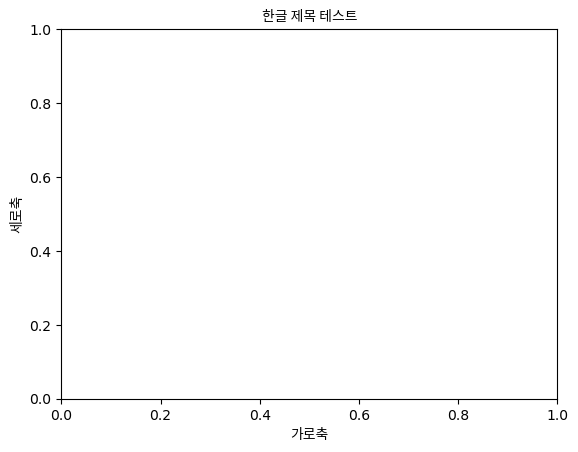

In [1]:
# 폰트 설정

from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager as fm
from matplotlib import rcParams

fp = FontProperties(fname="/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc")

plt.title("한글 제목 테스트", fontproperties=fp)
plt.xlabel("가로축", fontproperties=fp)
plt.ylabel("세로축", fontproperties=fp)
plt.show()

fp = fm.FontProperties(fname="/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc")
rcParams['font.family'] = fp.get_name()   # 파일에서 읽은 실제 이름 등록
rcParams['axes.unicode_minus'] = False

In [2]:

# ==== 경로 설정 ====
DATA_FILE = "/home/hschoi/data/leehyunwon/SleepHi/Sleep Hi_KSHS_2nd_data_250811.xlsx"         # 설문 데이터(.xlsx) # 날짜 형식 문제 있으면 _edited 사용할 것으로 예상했으나 코드 문제로 보임
META_FILE = "/home/hschoi/data/leehyunwon/SleepHi/Sleep Hi_Variable_250811.xlsx"       # 변수 메타데이터(.xlsx)
# OUT_DIR = "eda_results"                 # 결과 이미지 저장 폴더

# ==== 라이브러리 ====
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime as dt
import re
from sklearn.impute import SimpleImputer
from pandas.api.types import (
    is_datetime64_any_dtype, is_timedelta64_dtype,
    is_object_dtype, is_numeric_dtype
)
import re
import numpy as np
import pandas as pd
import datetime as dt
from pandas.api.types import (
    is_datetime64_any_dtype, is_timedelta64_dtype,
    is_object_dtype, is_numeric_dtype
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import logsumexp
from stepmix.stepmix import StepMix

# 선택 라이브러리 (미설치 시 주석 처리 가능)
try:
    from factor_analyzer import FactorAnalyzer
    HAS_FACTOR = True
except Exception:
    HAS_FACTOR = False
    print("[알림] factor_analyzer가 설치되어 있지 않습니다. (pip install factor-analyzer)")

# # 한글 폰트 설정 (환경에 따라 주석 필요)
# plt.rcParams['font.family'] = 'Noto Sans CJK KR'  # 환경에 맞게 변경하세요
# plt.rcParams['axes.unicode_minus'] = False

# os.makedirs(OUT_DIR, exist_ok=True)
print("환경 준비 완료.")


환경 준비 완료.


In [3]:

# ==== 데이터/메타데이터 로드 ====
df = pd.read_excel(DATA_FILE)
meta = pd.read_excel(META_FILE)

print("데이터 크기:", df.shape)
print("컬럼 예시:", df.columns[:10].tolist())

# 메타 필수 컬럼 체크
required_cols = {"변수명", "범주형", "연속형"}
missing_meta_cols = required_cols - set(meta.columns)
if missing_meta_cols:
    raise ValueError(f"메타데이터에 필요한 컬럼이 없습니다: {missing_meta_cols}")

# 범주/연속 변수 리스트
categorical_vars = meta.loc[meta["범주형"] == 1, "변수명"].dropna().astype(str).tolist()
continuous_vars = meta.loc[meta["연속형"] == 1, "변수명"].dropna().astype(str).tolist()

# 실제 df에 존재하는 컬럼만 사용
categorical_vars = [c for c in categorical_vars if c in df.columns]
continuous_vars = [c for c in continuous_vars if c in df.columns]

print("범주형 변수 개수:", len(categorical_vars))
print("연속형 변수 개수:", len(continuous_vars))


데이터 크기: (2501, 97)
컬럼 예시: ['ID', 'SW', 'sex', 'age', 'age_group', 'Q59_1_w', 'Q59_1_f', 'D3_1_ht', 'D3_2_wt', 'BMI']
범주형 변수 개수: 21
연속형 변수 개수: 75


In [4]:
# 특정 열의 값 하나 출력
print("예시 값:", df["MCTQ_GUa"].values[:5])
print("예시 값:", df["MCTQ_MSF"].values[:5])
print("예시 값:", df["MSF_mismatch_pristine"].values[:5])
print("예시 값:", df["MCTQ_MBF"].values[:5])
print("예시 값:", df["MCTQ_SOf_c"].values[:5])
print("예시 값:", df["MCTQ_SOa_c"].values[:5])
print("예시 값:", df["MCTQ_SOw_c"].values[:5])
print("예시 값:", df["MCTQ_TFPw"].values[:5])


# print("예시 값:", df_copy["MCTQ_GUa"].values[:5])
# print("예시 값:", df_copy["MCTQ_MSF"].values[:5])
# print("예시 값:", df_copy["MSF_mismatch_pristine"].values[:5])
# print("예시 값:", df_copy["MCTQ_MBF"].values[:5])
# print("예시 값:", df_copy["MCTQ_SOf_c"].values[:5])
# print("예시 값:", df_copy["MCTQ_SOa_c"].values[:5])
# print("예시 값:", df_copy["MCTQ_SOw_c"].values[:5])
# print("예시 값:", df_copy["MCTQ_TFPw"].values[:5])

예시 값: [datetime.time(10, 30) datetime.time(9, 4, 17, 143000)
 datetime.time(8, 22, 8, 571000) datetime.time(9, 55, 51, 429000)
 datetime.time(8, 18, 34, 286000)]
예시 값: [datetime.time(5, 40) datetime.time(5, 5) datetime.time(4, 32, 30)
 datetime.time(8, 20) datetime.time(4, 20)]
예시 값: [datetime.time(2, 10) datetime.time(0, 35) datetime.time(0, 2, 30)
 datetime.time(2, 50) datetime.time(0, 20)]
예시 값: [datetime.datetime(1900, 1, 1, 5, 45) datetime.datetime(1900, 1, 1, 4, 50)
 datetime.datetime(1900, 1, 1, 4, 32, 30)
 datetime.datetime(1900, 1, 1, 8, 1, 30)
 datetime.datetime(1900, 1, 1, 4, 20)]
예시 값: [datetime.datetime(1900, 1, 1, 0, 20) datetime.datetime(1900, 1, 1, 0, 40)
 datetime.datetime(1900, 1, 1, 0, 5) datetime.datetime(1900, 1, 1, 3, 40)
 datetime.datetime(1900, 1, 1, 0, 10)]
예시 값: [datetime.datetime(1900, 1, 1, 1, 28, 34, 286000)
 datetime.datetime(1900, 1, 1, 0, 4, 17, 143000)
 datetime.datetime(1900, 1, 1, 0, 5)
 datetime.datetime(1900, 1, 1, 3, 25, 42, 857000)
 datetime.datet

# 결측치 관리 : 평균or0처리, 아니면 결측치 전부 제거(일단 후자로 진행)

In [ ]:
# # 결측치 평균값으로 두고 아예 없으면 0으로 두기, 하고 나서 위에 결측치 플롯 다시 해보기 (카테고리 값은 제외되었으니 위의 플롯에 카테고리만 보일 것)

# # Get a list of only the numeric columns
# numeric_cols = df.select_dtypes(include=np.number).columns

# # Loop through the numeric columns
# for column in numeric_cols:
#     # Calculate the mean of the column, ignoring NaNs
#     mean_value = df[column].mean()

#     # If the mean is NaN (the entire column is null), set it to 0
#     if pd.isna(mean_value):
#         mean_value = 0

#     # Fill the null values in the column with the calculated mean
#     df[column].fillna(mean_value, inplace=True)

/tmp/ipykernel_145394/278591438.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(mean_value, inplace=True)


In [5]:
# 이번엔 다른 작업, 하나라도 NaN이 있으면 해당 행 제거
df_clean = df.dropna()

print("원래 행 개수:", len(df))
print("결측치 제거 후 행 개수:", len(df_clean))


df = df_clean.copy()

원래 행 개수: 2501
결측치 제거 후 행 개수: 2363


# 시간 값 변환

In [6]:
# 숫자 duration(ns/us/ms/s/h/min)을 원소별 '분'으로 환산
def _numeric_duration_to_minutes_elwise(arr: pd.Series) -> pd.Series:
    v = pd.to_numeric(arr, errors="coerce").astype("float").to_numpy()
    out = np.full_like(v, np.nan, dtype="float64")
    a = np.abs(v)

    ns = (a >= 1e11)                             # 예: 1.8e12 ≈ 30분(ns)
    us = (~ns) & (a >= 1e8)                      # μs
    ms = (~ns) & (~us) & (a >= 1e6)              # ms
    sec= (~ns) & (~us) & (~ms) & (a >= 60)       # s
    minute = (~ns) & (~us) & (~ms) & (~sec) & (a > 0) & (a <= 24*60)
    hour   = (~ns) & (~us) & (~ms) & (~sec) & (~minute) & (a > 0)

    out[ns]     = v[ns]    / (1e9 * 60.0)
    out[us]     = v[us]    / (1e6 * 60.0)
    out[ms]     = v[ms]    / (1e3 * 60.0)
    out[sec]    = v[sec]   / 60.0
    out[minute] = v[minute]
    out[hour]   = v[hour]  * 60.0

    # 0은 유효값
    out[np.isfinite(v) & (v == 0)] = 0.0
    return pd.Series(out, index=arr.index)

_hhmm_pat = re.compile(r"^(\d{1,2}):(\d{2})(?::(\d{2})(?:\.(\d+)?)?)?$")

def _safe_to_minutes_scalar(x):
    """단일 값 x를 '분(float)'으로. 해석 불가 시 np.nan (→ 열 전체 변환 스킵 트리거)."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return np.nan

    # python datetime/time
    if isinstance(x, dt.time):
        return x.hour*60 + x.minute + x.second/60.0
    if isinstance(x, dt.datetime):
        return x.hour*60 + x.minute + x.second/60.0

    # pandas 계열
    if isinstance(x, pd.Timestamp):
        return x.hour*60 + x.minute + x.second/60.0
    if isinstance(x, pd.Timedelta):
        return x.total_seconds()/60.0
    if isinstance(x, np.datetime64):
        try:
            ts = pd.to_datetime(x)
            return ts.hour*60 + ts.minute + ts.second/60.0
        except Exception:
            return np.nan

    # 숫자: duration 단위 추정
    if isinstance(x, (int, float, np.integer, np.floating)):
        if np.isnan(x): 
            return np.nan
        v = float(x); av = abs(v)
        if av >= 1e11: return v/(1e9*60.0) # ns
        if av >= 1e8:  return v/(1e6*60.0) # μs
        if av >= 1e6:  return v/(1e3*60.0) # ms
        if av >= 60:   return v/60.0       # s
        if 0 <= v <= 24*60: return v       # 분
        return v*60.0                       # 시간

    # 문자열: timedelta → datetime → HH:MM(:SS) → 숫자 문자열
    if isinstance(x, str):
        sx = x.strip()
        if not sx:
            return np.nan
        try:
            td = pd.to_timedelta(sx)
            if isinstance(td, pd.Timedelta) or hasattr(td, "components"):
                return float(td.total_seconds())/60.0
        except Exception:
            pass
        try:
            ts = pd.to_datetime(sx)
            if isinstance(ts, pd.Timestamp):
                return ts.hour*60 + ts.minute + ts.second/60.0
        except Exception:
            pass
        m = _hhmm_pat.match(sx)
        if m:
            h, m_, s_ = int(m.group(1)), int(m.group(2)), int(m.group(3) or 0)
            return h*60 + m_ + s_/60.0
        try:
            fv = float(sx.replace(",", ""))
            return _safe_to_minutes_scalar(fv)
        except Exception:
            return np.nan

    return np.nan

def series_to_minutes_strict(s: pd.Series) -> (pd.Series, pd.Series):
    """
    시리즈 전체를 '분'으로 변환.
    - dtype별 최적 경로 사용, object 혼합은 원소별 안전 파서 사용
    - 반환: (minutes_series, ok_mask) ; ok_mask=False가 하나라도 있으면 열 전체 변환 스킵
    """
    if is_timedelta64_dtype(s):
        out = (s.dt.total_seconds() / 60.0).astype("float")
        ok = s.notna() | (out == 0.0)
        return out, ok

    if is_datetime64_any_dtype(s):
        out = (s.dt.hour*60 + s.dt.minute + s.dt.second/60.0).astype("float")
        ok = s.notna() | (out == 0.0)
        return out, ok

    if is_numeric_dtype(s):
        out = _numeric_duration_to_minutes_elwise(s).astype("float")
        ok = out.notna() | (out == 0.0)
        return out, ok

    # object 혼합형: 안전 파서로 원소별 처리
    out = s.map(_safe_to_minutes_scalar).astype("float")
    ok  = out.notna() | (out == 0.0)
    return out, ok

def looks_time_like_series(s: pd.Series, sample_n: int = 200) -> bool:
    """연속형 후보 중 '시간/지속시간'으로 보이는지 휴리스틱 판정."""
    if is_datetime64_any_dtype(s) or is_timedelta64_dtype(s):
        return True
    if is_object_dtype(s):
        smp = s.dropna().astype(str).head(sample_n)
        if smp.empty: 
            return False
        if smp.str.contains(r"\bdays\b|^\s*\d{1,2}:\d{2}(:\d{2}(\.\d+)?)?$|^1900-01-01", regex=True).any():
            return True
        has_dt_like = s.dropna().map(lambda v: isinstance(v, (dt.time, dt.datetime, pd.Timestamp, pd.Timedelta, np.datetime64))).any()
        if has_dt_like:
            return True
    if is_numeric_dtype(s):
        smp = s.dropna().astype(float).abs().head(sample_n)
        if smp.empty:
            return False
        if (smp.ge(1e6).mean() > 0.05) or (smp.between(0, 24*60).mean() > 0.5):
            return True
    return False

def convert_time_columns_inplace_for_efa(df: pd.DataFrame, continuous_vars: list):
    """
    - continuous_vars 중 시간/지속시간으로 보이는 열만 골라 in-place로 분(float)로 변환
    - 한 값이라도 실패하면 그 열은 변환하지 않음(원본 유지)
    - 반환: {'converted': [...], 'skipped': [...], 'issues': DataFrame, 'efa_cols': [...]}
    """
    converted, skipped, issues = [], [], []

    # 시간/지속시간 후보만 선별
    time_like_candidates = [c for c in continuous_vars if c in df.columns and not is_numeric_dtype(df[c]) and looks_time_like_series(df[c])]

    for col in time_like_candidates:
        minutes, ok = series_to_minutes_strict(df[col])
        if ok.all():
            # 원본 열을 '분(float)'로 덮어쓰기
            df[col] = minutes.astype("float")
            converted.append(col)
        else:
            skipped.append(col)
            bad = ~ok
            bad_examples = df.loc[bad, col].astype(str).value_counts().head(10)
            issues.append({
                "column": col,
                "n_total": int(len(df)),
                "n_failed": int(bad.sum()),
                "examples": "; ".join([f"{k} x{v}" for k, v in bad_examples.items()])
            })

    # EFA에 실제로 투입 가능한 연속형 열(숫자형만)
    efa_cols = [c for c in continuous_vars if c in df.columns and is_numeric_dtype(df[c])]

    issues_df = pd.DataFrame(issues).sort_values("n_failed", ascending=False) if issues else pd.DataFrame(columns=["column","n_total","n_failed","examples"])

    return {
        "converted": converted,
        "skipped": skipped,
        "issues": issues_df,
        "efa_cols": efa_cols
    }

# ===== 실행부 =====
# continuous_vars는 질문에서 이미 만들어져 있다고 가정
report = convert_time_columns_inplace_for_efa(df, continuous_vars)

print("[변환 완료 요약]")
print("  변환 성공 열 수:", len(report["converted"]))
if report["converted"]:
    print("   └", report["converted"])

print("  변환 스킵 열 수:", len(report["skipped"]))
if report["skipped"]:
    print("   └", report["skipped"])
    print("\n[스킵 사유(문제 값 예시)]")
    print(report["issues"].to_string(index=False))

# EFA 투입 열 목록 (숫자형만)
efa_cols = report["efa_cols"]
print("\n[EFA 열 개수]:", len(efa_cols))
# 이제 바로 EFA:
# X_efa = df[efa_cols].copy()
# print("EFA 입력 크기:", X_efa.shape)

[변환 완료 요약]
  변환 성공 열 수: 29
   └ ['MCTQ_BTw_c', 'MCTQ_BTf_c', 'MCTQ_BTa_c', 'MCTQ_GUw', 'MCTQ_GUf', 'MCTQ_GUa', 'MCTQ_MBW', 'MCTQ_MBF', 'MCTQ_Sprepw_c', 'MCTQ_Sprepf_c', 'MCTQ_Sprepa_c', 'MCTQ_TFPw', 'MCTQ_TFPf', 'MCTQ_TFPa', 'MCTQ_SOw_c', 'MCTQ_SOf_c', 'MCTQ_SOa_c', 'MCTQ_SEw', 'MCTQ_SEf', 'MCTQ_SEa', 'MCTQ_MSW', 'MCTQ_MSF', 'Pristine_SO_c', 'Pristine_SE', 'Pristine_MS', 'SO_mismatch_pristine', 'SE_mismatch_pristine', 'MSW_mismatch_pristine', 'MSF_mismatch_pristine']
  변환 스킵 열 수: 0

[EFA 열 개수]: 75


/tmp/ipykernel_272826/2823622462.py:125: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if smp.str.contains(r"\bdays\b|^\s*\d{1,2}:\d{2}(:\d{2}(\.\d+)?)?$|^1900-01-01", regex=True).any():
/tmp/ipykernel_272826/2823622462.py:125: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if smp.str.contains(r"\bdays\b|^\s*\d{1,2}:\d{2}(:\d{2}(\.\d+)?)?$|^1900-01-01", regex=True).any():
/tmp/ipykernel_272826/2823622462.py:125: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if smp.str.contains(r"\bdays\b|^\s*\d{1,2}:\d{2}(:\d{2}(\.\d+)?)?$|^1900-01-01", regex=True).any():
/tmp/ipykernel_272826/2823622462.py:125: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract

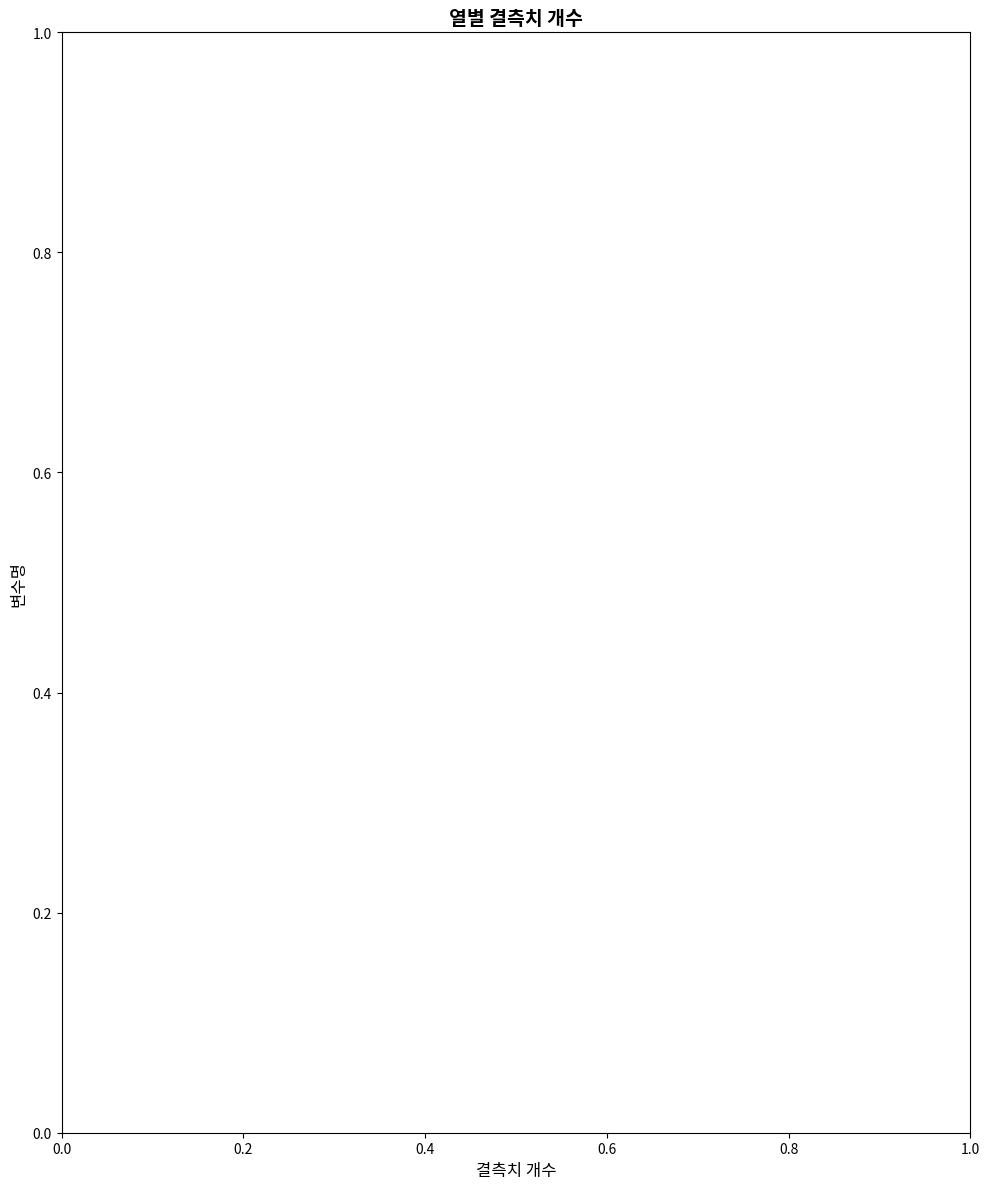

In [7]:
# 1. 열별 결측치 개수 계산
missing_counts = df.isnull().sum()

# 2. 결측치 있는 열만 추림 & 내림차순 정렬
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

# 3. Barplot 시각화
plt.figure(figsize=(10, 12))
sns.barplot(x=missing_counts.values, y=missing_counts.index, palette="Blues_r")
plt.xlabel("결측치 개수", fontsize=12)
plt.ylabel("변수명", fontsize=12)
plt.title("열별 결측치 개수", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

# 임시 : hh:mm타입 값들 히스토그램 뽑기

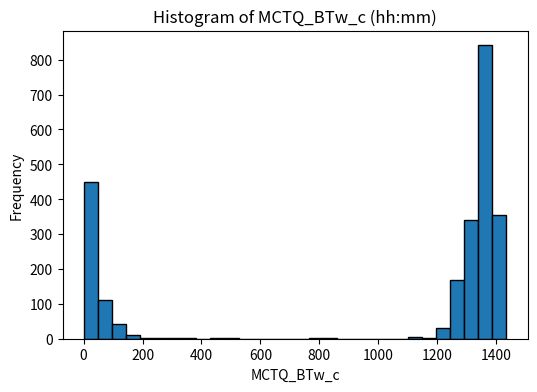

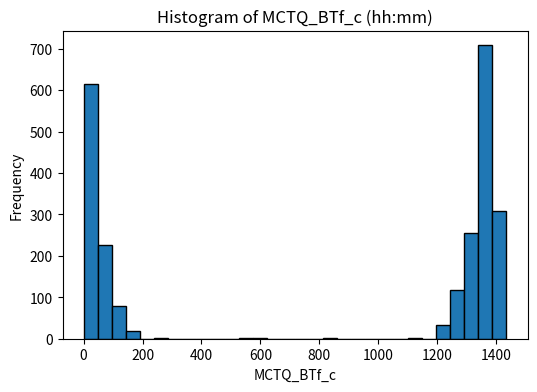

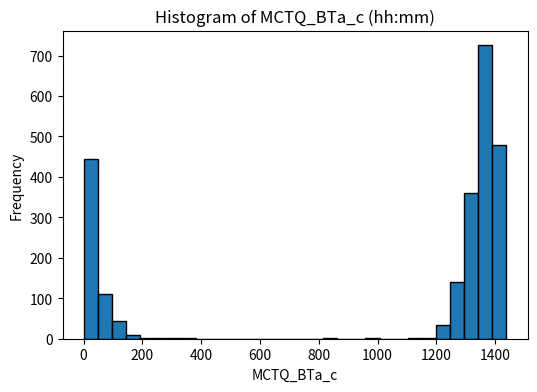

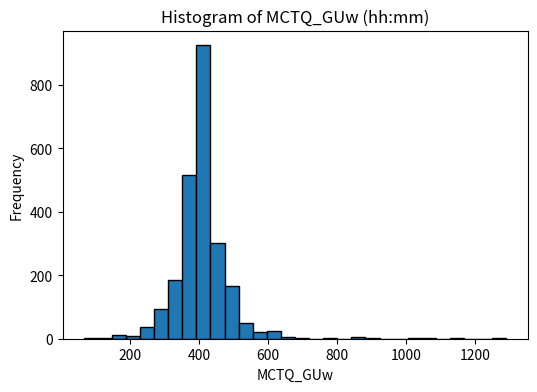

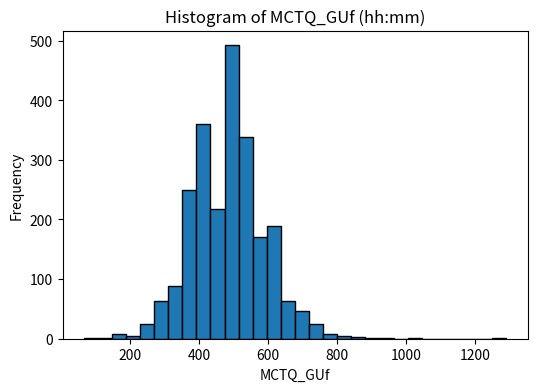

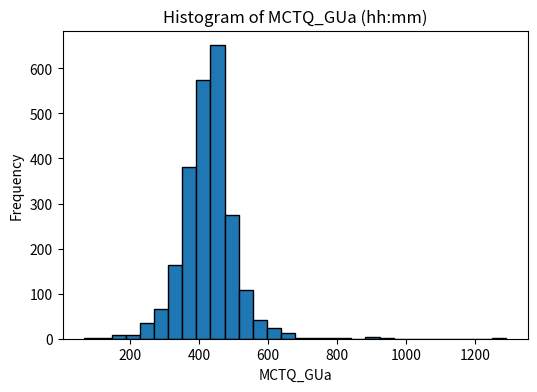

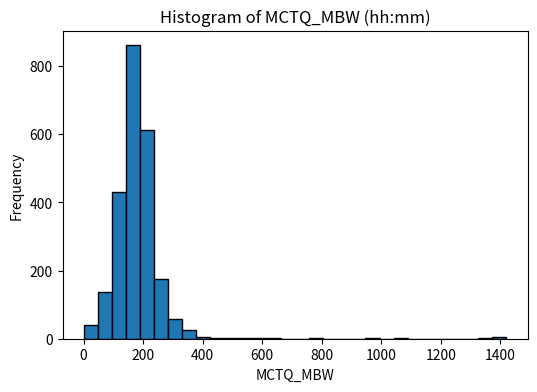

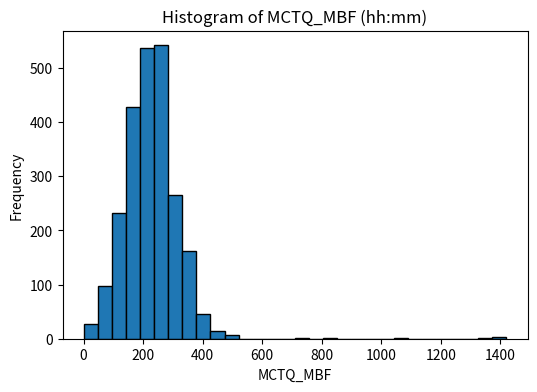

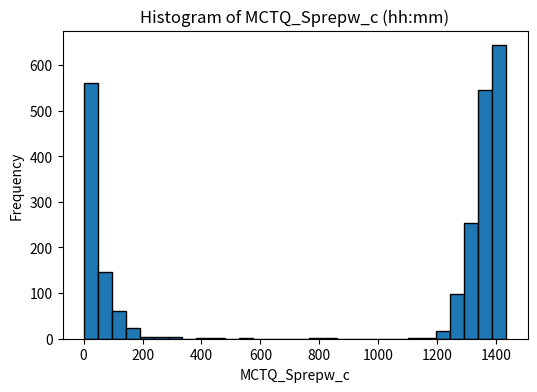

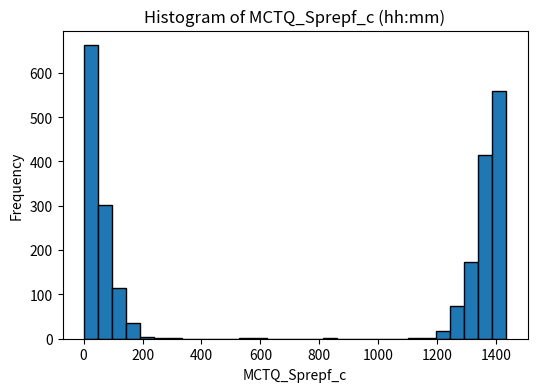

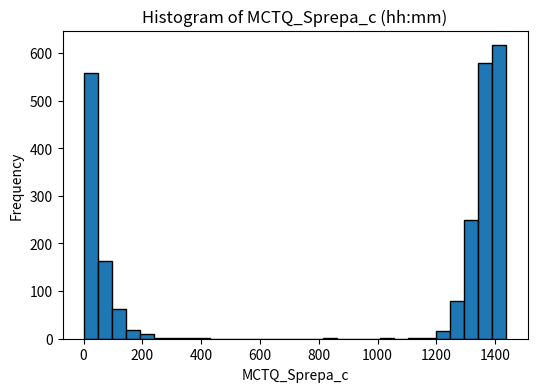

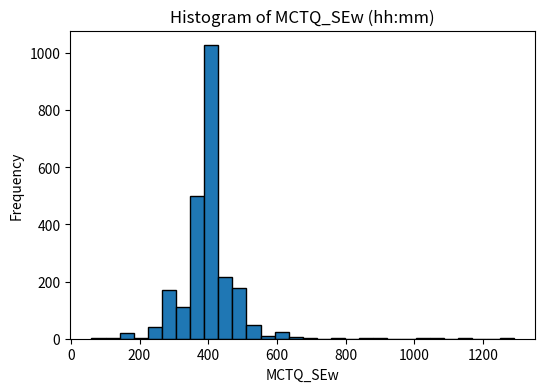

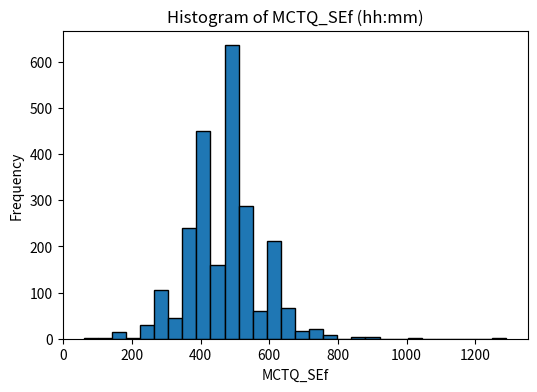

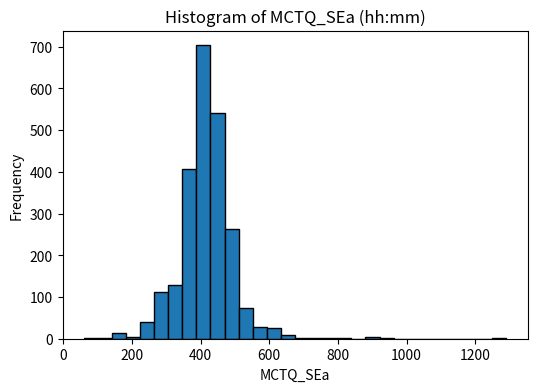

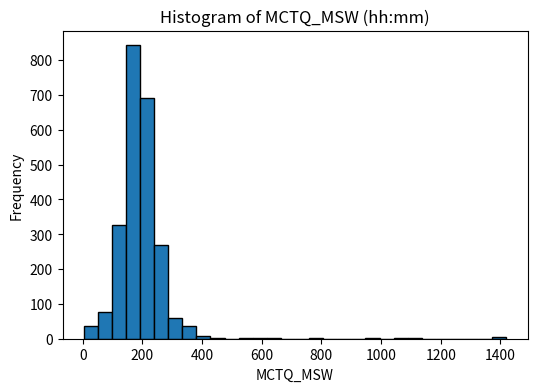

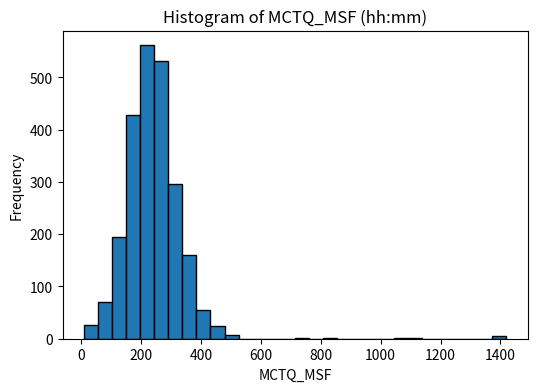

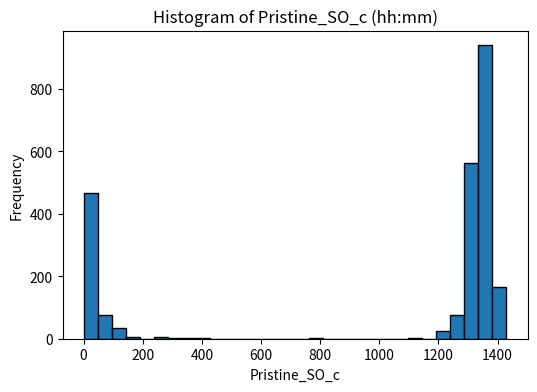

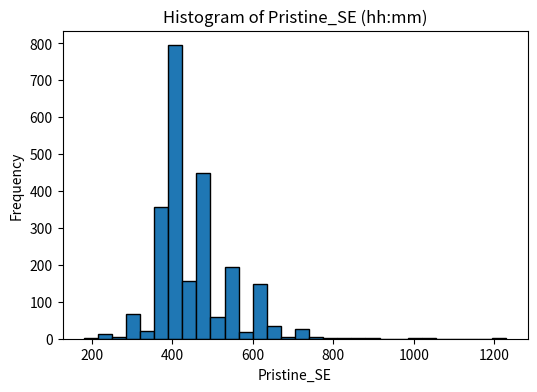

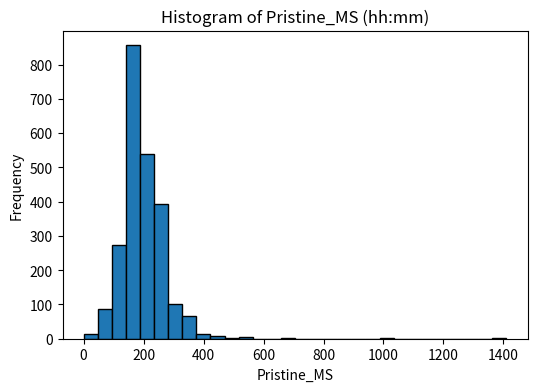

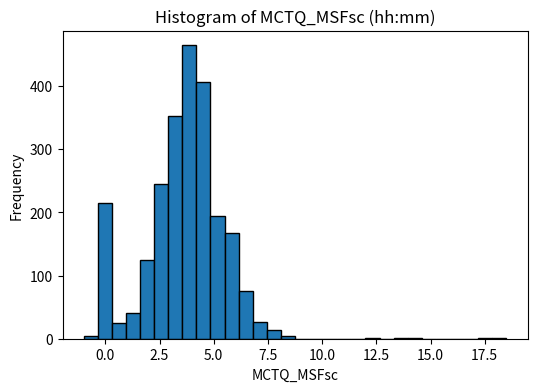

In [8]:
# 메타 파일에서 타입이 'hh:mm'인 변수명 선택
hhmm_vars = meta.loc[meta['타입'] == 'hh:mm', '변수명'].tolist()

# 해당 변수들만 반복해서 히스토그램 플롯
for col in hhmm_vars:
    if col in df.columns:
        plt.figure(figsize=(6, 4))
        plt.hist(df[col].dropna(), bins=30, edgecolor='black')
        plt.title(f"Histogram of {col} (hh:mm)")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()

# EFA 시작

[EFA] 고유값(Eigenvalues): [6.7606e+00 6.0697e+00 3.1180e+00 2.2133e+00 2.0966e+00 1.1987e+00
 9.0280e-01 5.3220e-01 4.4970e-01 4.1290e-01 3.4860e-01 2.8620e-01
 1.8180e-01 1.3330e-01 7.8800e-02 6.9300e-02 6.0600e-02 5.2400e-02
 2.6000e-02 3.7000e-03 3.0000e-03 1.8000e-03 0.0000e+00 0.0000e+00
 0.0000e+00]


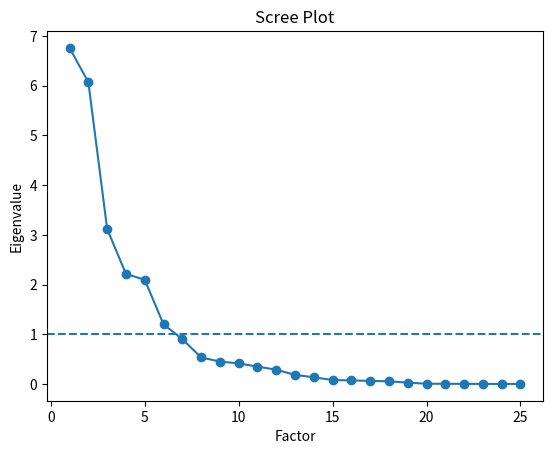

In [8]:
# ==== 스크리 플롯 전용: 요인 수 가늠 ==== ** 카테고리 값은 EFA에 넣어봤자 의미 없으니 제외, 결측치 0으로 채울 시 전부 없어서 평균이 0인 경우의 열도 제외, 셋 중 하나만 살릴 것 **
                                                                                    # 결측치를 전부 제거한 경우에도 일단은 돌려둠 : 어차피 분산이 0인 경우도 제외해야 하므로


# ==== 수면기회 (Opportunity) ====

fa_vars = [c for c in [
"MCTQ_BTw_c",    # 근무날 침대로 들어가는 시각
"MCTQ_BTf_c",    # 쉬는날 침대로 들어가는 시각
"MCTQ_BTa_c",    # 평균 침대로 들어가는 시각
"MCTQ_GUw",    # 근무날 침대에서 나오는 시각
"MCTQ_GUf",    # 쉬는날 침대에서 나오는 시각
"MCTQ_GUa",    # 평균 침대에서 나오는 시각
"MCTQ_MBW",    # 근무날 침대에 있는 시각 중간점
"MCTQ_MBF",    # 쉬는날 침대에 있는 시각 중간점
"MCTQ_Sprepw_c",    # 근무날 잠 잘 준비가 된 시각
"MCTQ_Sprepf_c",    # 쉬는날 잠 잘 준비가 된 시각
"MCTQ_Sprepa_c",    # 평균 잠 잘 준비가 된 시간
"MCTQ_TBTw_c",    # 근무날 침대에 있는 시간
"MCTQ_TBTf_c",    # 쉬는날 침대에 있는 시간
"MCTQ_TBTa_c",    # 평균 침대에 있는 시간
"MCTQ_TFSw",    # 근무날 수면을 위한 시간
"MCTQ_TFSf",    # 쉬는날 수면을 위한 시간
"MCTQ_TFSa",    # 평균 수면을 위한 시간
"MCTQ_TFPw",    # 근무날 취침 전 지연행동 시간
"MCTQ_TFPf",    # 쉬는날 취침 전 지연행동 시간
"MCTQ_TFPa",    # 평균 취침 전 지연행동 시간
"Q64_SIw",    # 근무날 기상 후 지연행동 시간
"Q74_SIf",    # 쉬는날 기상 후 지연행동 시간
"MCTQ_SIa",    # 평균 기상 후 지연행동 시간
"MCTQ_SJL_bed",    # 근무날/쉬는날 침대에 있는 시간 중간점 차이
"MCTQ_bed_reg",    # 근무날/쉬는날 침대에 있는 시간의 상대적 차이
] if c in df.columns]



# ==== 수면능력 (Ability) ====

# fa_vars = [c for c in [
# "MCTQ_SDw_c",    # 근무날 수면시간
# "MCTQ_SDf_c",    # 쉬는날 수면시간
# "MCTQ_SDa_c",    # 평균 수면시간
# "Q62_SLatw",    # 근무날 수면잠복기
# "Q72_SLatf",    # 쉬는날 수면잠복기
# "MCTQ_Slata",    # 평균 수면잠복기
# "MCTQ_SE_w_c",    # 근무날 수면효율
# "MCTQ_SE_f_c",    # 쉬는날 수면효율
# "MCTQ_SE_a_c",    # 평균 수면효율
# "MCTQ_SOw_c",    # 근무날 잠드는 시각
# "MCTQ_SOf_c",    # 쉬는날 잠드는 시각
# "MCTQ_SOa_c",    # 평균 잠드는 시각
# "MCTQ_SEw",    # 근무날 잠에서 깬 시각
# "MCTQ_SEf",    # 쉬는날 잠에서 깬 시각
# "MCTQ_SEa",    # 평균 잠에서 깬 시각
# "MCTQ_MSW",    # 근무날 수면시각 중간점
# "MCTQ_MSF",    # 쉬는날 수면시각 중간점
# "MCTQ_SJL",    # 근무날/쉬는날 수면시간 중간점 차이
# "MCTQ_sleep_reg",    # 근무날/쉬는날 수면시간의 상대적 차이
# "ISI_sum",    # 불면증 심각도 척도 (ISI)
# "PSQI_sum_WA",    # 피처버그 수면의 질 지수 (PSQI)
# ] if c in df.columns]



# ==== 수면필요 (Need) ====

# fa_vars = [c for c in [
# "Q51_slp_sufficient",    # 야간수면 충분도
# "Q91_ISI_4",    # 수면양상 만족도
# "MCTQ_CUS",    # 주말 수면 보충 시간
# "desired_sd_min",    # 충분하다고 생각하는 수면 시간
# "Pristine_SD",    # Pristine 평가 수면시간
# "SD_mismatch_desired",    # 충분수면시간과 실제 차이
# "SD_mismatch_pristine",    # Pristine 평가 수면시간과 실제 차이
# "nap_n",    # 낮잠횟수
# "Q48_nap_dur",    # 낮잠시간
# "ESS_sum",    # 앱워스 졸음척도 (ESS)
# "inertia",    # 수면관성 (기상 후 머리가 맑아질때까지 시간)
# "FSS_sum",    # 피로 증상 척도 (FSS)
# "Pristine_SO_c",    # Pristine 평가 잠드는 시각
# "Pristine_SE",    # Pristine 평가 잠에서 깬 시각
# "Pristine_MS",    # Pristine 평가 수면시각 중간점
# "SO_mismatch_pristine",    # Pristine 평가 잠드는 시각과 실제 차이
# "SE_mismatch_pristine",    # Pristine 평가 잠에서 깬 시각과 실제 차이
# "MSW_mismatch_pristine",    # Pristine 평가 수면시각 중간점과 실제 차이
# "MSF_mismatch_pristine",    # Pristine 평가 잠드는 시각과 실제 잠드는 시각 차이
# "MCTQ_MSFsc",    # 일주기유형
# ] if c in df.columns]


# # ==== 전체 연속값 ====
# fa_vars = continuous_vars



if len(fa_vars) < 3:
    raise ValueError(f"[skip] 요인분석 변수 수 부족: {fa_vars}")

# --- 정제 단계 ---
X = df[fa_vars].copy()
X = X.apply(pd.to_numeric, errors='coerce')
X = X.replace([np.inf, -np.inf], np.nan)

# 1) 전부 결측 열 확인
all_nan_cols = X.columns[X.isna().all()]
if len(all_nan_cols) > 0:
    print("[제거] 전부 결측인 열:", list(all_nan_cols))
X = X.drop(columns=all_nan_cols)

# 2) 중앙값 대치
imp = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)

# 3) 분산 0(또는 극소) 열 확인
stds = X_imp.std(ddof=0)
zero_var_cols = stds[stds <= 1e-12].index
if len(zero_var_cols) > 0:
    print("[제거] 분산≈0인 열:", list(zero_var_cols))
X_imp = X_imp.drop(columns=zero_var_cols)

# 4) 상관행렬 NaN 발생 여부 점검
corr = X_imp.corr()
bad_in_corr = corr.columns[corr.isna().any()].tolist()
if len(bad_in_corr) > 0:
    print("[경고] 상관행렬에서 NaN 발생한 열:", bad_in_corr)

# 5) 변수 수 최종 확인
if X_imp.shape[1] < 3:
    raise ValueError(f"[중단] 정제 후 변수 수 부족: {list(X_imp.columns)}")

# --- 스크리 플롯 ---
fa_scree = FactorAnalyzer(rotation=None)
fa_scree.fit(X_imp)

eigenvals, _ = fa_scree.get_eigenvalues()
print("[EFA] 고유값(Eigenvalues):", np.round(eigenvals[:X_imp.shape[1]], 4))

plt.figure()
plt.plot(range(1, len(eigenvals) + 1), eigenvals, marker='o')
plt.axhline(1, linestyle='--')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.show()


               Factor1  Factor2  Factor3  Factor4
MCTQ_BTw_c       0.826    0.180   -0.021    0.006
MCTQ_BTf_c       0.753    0.106   -0.158    0.000
MCTQ_BTa_c       0.847    0.167   -0.013    0.005
MCTQ_GUw        -0.561    0.633    0.100    0.094
MCTQ_GUf        -0.462    0.357    0.754    0.084
MCTQ_GUa        -0.591    0.613    0.319    0.107
MCTQ_MBW        -0.577    0.141    0.122   -0.025
MCTQ_MBF        -0.551    0.095    0.473   -0.002
MCTQ_Sprepw_c    0.834    0.202   -0.047   -0.122
MCTQ_Sprepf_c    0.705    0.115   -0.175   -0.094
MCTQ_Sprepa_c    0.855    0.195   -0.065   -0.103
MCTQ_TBTw_c      0.219    0.931   -0.114    0.235
MCTQ_TBTf_c      0.085    0.590    0.692    0.175
MCTQ_TBTa_c      0.198    0.926    0.129    0.248
MCTQ_TFSw        0.223    0.945   -0.097   -0.139
MCTQ_TFSf        0.080    0.596    0.661   -0.100
MCTQ_TFSa        0.201    0.942    0.138   -0.141
MCTQ_TFPw        0.028    0.007   -0.015    0.815
MCTQ_TFPf        0.039   -0.008    0.054    0.693


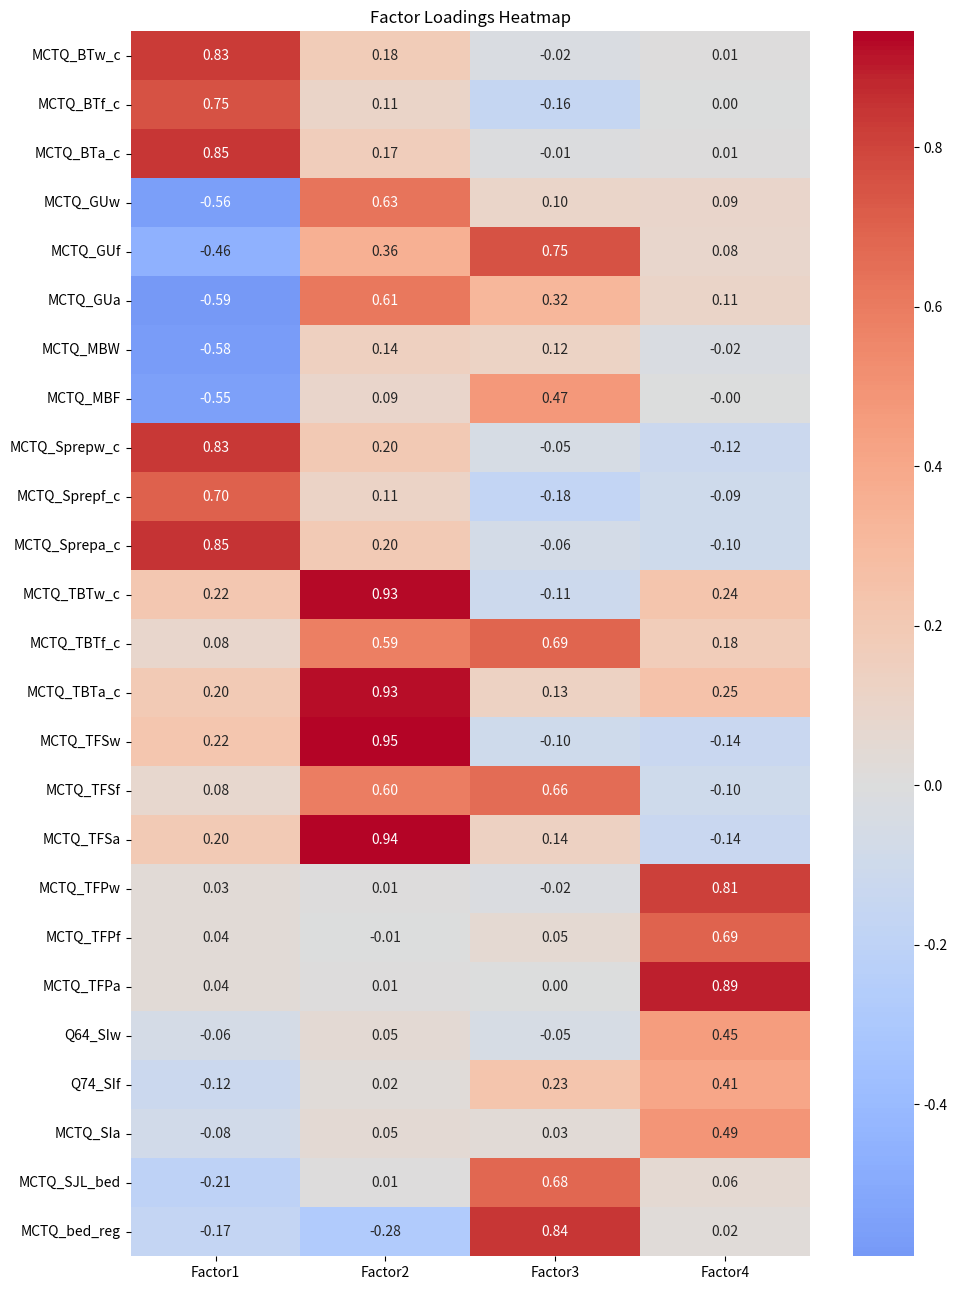

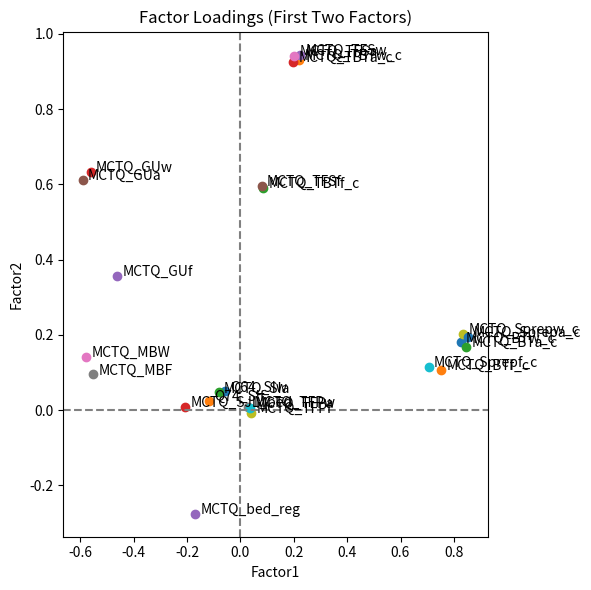

In [10]:
# EFA 시작, 저 밑에 N_FACTORS 설정 후 실행!!!!!

def preprocess_for_fa(df, fa_vars, min_var=1e-12):
    """EFA용 전처리: 숫자화→Inf/NaN 처리→전부 결측 열 제거→중앙값 대치→분산≈0 열 제거"""
    X = df[fa_vars].copy()
    X = X.apply(pd.to_numeric, errors='coerce')
    X = X.replace([np.inf, -np.inf], np.nan)

    # 전부 결측 열 제거
    all_nan_cols = X.columns[X.isna().all()]
    if len(all_nan_cols) > 0:
        X = X.drop(columns=all_nan_cols)

    # 중앙값 대치
    imp = SimpleImputer(strategy='median')
    X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)

    # 분산≈0 열 제거
    stds = X_imp.std(ddof=0)
    keep = stds > min_var
    X_imp = X_imp.loc[:, keep]

    # 남은 열이 최소 3개 미만이면 EFA 불가
    if X_imp.shape[1] < 3:
        raise ValueError(f"[중단] 정제 후 변수 수 부족: {list(X_imp.columns)}")

    return X_imp

# ==== 사용자가 선택한 요인 수 ====
N_FACTORS = 4   # <- 스크리 플롯 보고 결정

# fa_vars 는 기존과 동일하게 정의되어 있다고 가정
X_imp = preprocess_for_fa(df, fa_vars)   # ✅ 스크리플롯과 동일 전처리 적용

# (선택) 표준화: 스케일 차이가 크면 권장
# X_imp = (X_imp - X_imp.mean()) / X_imp.std(ddof=0)

# N_FACTORS 검증: 변수 수를 넘을 수 없음
max_factors = min(X_imp.shape[1]-1, X_imp.shape[0]-1)  # 보수적으로 제한
if N_FACTORS > max_factors:
    raise ValueError(f"N_FACTORS={N_FACTORS}가 허용치({max_factors})를 초과")

# 1-요인일 때 varimax 회전은 의미가 거의 없음(keep 그대로 사용해도 무방)
fa = FactorAnalyzer(n_factors=N_FACTORS, rotation="varimax")
fa.fit(X_imp)

# 적재치 행렬
cols = [f"Factor{i+1}" for i in range(N_FACTORS)]
loadings = pd.DataFrame(fa.loadings_, index=X_imp.columns, columns=cols)
print(loadings.round(3))

# # ---- Heatmap (축 개수 제한 없음) ----
# plt.figure(figsize=(1.5*N_FACTORS+4, 0.4*len(loadings)+3))
# sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0, fmt=".2f")
# plt.title("Factor Loadings Heatmap")
# plt.tight_layout()
# plt.show()


# ---- Heatmap (축 개수 제한 없음, 단 변수 많으면 단순화) ----
MAX_ANNOT_VARS = 40  # 이 값 넘으면 숫자 제거 + 크기 간소화

n_vars = len(loadings)
annot_flag = n_vars <= MAX_ANNOT_VARS

fig_height = min(0.4 * n_vars + 3, 25)  # 세로축 최대 크기 제한 (예: 25인치)

plt.figure(figsize=(1.5*N_FACTORS+4, fig_height))
sns.heatmap(
    loadings,
    annot=annot_flag,
    cmap="coolwarm",
    center=0,
    fmt=".2f" if annot_flag else "",
    cbar=True
)
plt.title("Factor Loadings Heatmap" + ("" if annot_flag else " (values hidden)"))
plt.tight_layout()
plt.show()



# ---- Loading Scatter: 앞 두 축만 ----
if N_FACTORS >= 2:
    plt.figure(figsize=(6,6))
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    for var in loadings.index:
        x, y = loadings.loc[var, "Factor1"], loadings.loc[var, "Factor2"]
        plt.scatter(x, y)
        plt.text(x + 0.02, y, var)
    plt.xlabel("Factor1")
    plt.ylabel("Factor2")
    plt.title("Factor Loadings (First Two Factors)")
    plt.tight_layout()
    plt.show()
else:
    print("[info] N_FACTORS=1: 산점도(2D) 생략")

In [11]:
# 공통성 / 특이성 계산
communalities = pd.Series(fa.get_communalities(), index=X_imp.columns, name="Communality")
uniqueness    = pd.Series(fa.get_uniquenesses(), index=X_imp.columns, name="Uniqueness")

result = pd.concat([communalities, uniqueness], axis=1).round(3)
print(result)


               Communality  Uniqueness
MCTQ_BTw_c           0.715       0.285
MCTQ_BTf_c           0.603       0.397
MCTQ_BTa_c           0.745       0.255
MCTQ_GUw             0.735       0.265
MCTQ_GUf             0.917       0.083
MCTQ_GUa             0.838       0.162
MCTQ_MBW             0.368       0.632
MCTQ_MBF             0.536       0.464
MCTQ_Sprepw_c        0.753       0.247
MCTQ_Sprepf_c        0.550       0.450
MCTQ_Sprepa_c        0.783       0.217
MCTQ_TBTw_c          0.982       0.018
MCTQ_TBTf_c          0.865       0.135
MCTQ_TBTa_c          0.974       0.026
MCTQ_TFSw            0.972       0.028
MCTQ_TFSf            0.808       0.192
MCTQ_TFSa            0.966       0.034
MCTQ_TFPw            0.665       0.335
MCTQ_TFPf            0.485       0.515
MCTQ_TFPa            0.798       0.202
Q64_SIw              0.215       0.785
Q74_SIf              0.234       0.766
MCTQ_SIa             0.248       0.752
MCTQ_SJL_bed         0.509       0.491
MCTQ_bed_reg         0.81

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;
&nbsp;
&nbsp;
# 이하는 CFA 및 카이제곱 (여기선 보류)

In [ ]:
# EFA 결과를 바탕으로 CFA 모델링 (단, 별도의 데이터셋이 필요하므로 코드를 돌리긴 했지만 유의한 지표는 아님)

from semopy import Model
import pandas as pd

# CFA 모델 정의 (lavaan-style syntax) -> EFA 결과에 맞게 임의로 판단
desc = """
Factor1 =~ GAD_sum + PHQ_sum
Factor2 =~ ISI_sum + ESS_sum + FSS_sum
"""

model = Model(desc)
model.fit(df)  # df는 원 데이터셋 (관찰변수들 포함된 DataFrame)

# 요인 부하량, 적합도 지표 확인
est = model.inspect()
print(est)

from semopy import calc_stats
stats = calc_stats(model)
print(stats)


       lval  op     rval   Estimate  Std. Err    z-value p-value
0   GAD_sum   ~  Factor1   1.000000         -          -       -
1   PHQ_sum   ~  Factor1   2.111087   0.08559  24.665007     0.0
2   ISI_sum   ~  Factor2   1.000000         -          -       -
3   ESS_sum   ~  Factor2   0.639267  0.033656  18.994135     0.0
4   FSS_sum   ~  Factor2   2.422078  0.103737  23.348184     0.0
5   Factor1  ~~  Factor1   2.387537   0.14733  16.205376     0.0
6   Factor2  ~~  Factor2   9.374519   0.60971  15.375367     0.0
7   Factor2  ~~  Factor1   3.431438  0.200105  17.148172     0.0
8   ESS_sum  ~~  ESS_sum  12.049800  0.386385  31.185993     0.0
9   FSS_sum  ~~  FSS_sum  58.355750   2.59458  22.491409     0.0
10  GAD_sum  ~~  GAD_sum   2.683471  0.112513  23.850234     0.0
11  ISI_sum  ~~  ISI_sum  12.015167  0.486589  24.692662     0.0
12  PHQ_sum  ~~  PHQ_sum   3.484726  0.383111   9.095866     0.0
       DoF  DoF Baseline        chi2  chi2 p-value  chi2 Baseline      CFI  \
Value    4  

In [ ]:

# ==== 카이제곱 (두 범주형 변수의 독립성 유무) ====
from scipy.stats import chi2_contingency

def chi_square_two(frame, col_a, col_b):
    if col_a not in frame.columns or col_b not in frame.columns:
        print(f"[skip] {col_a} 또는 {col_b} 없음")
        return
    ct = pd.crosstab(frame[col_a], frame[col_b])
    if ct.shape[0] < 2 or ct.shape[1] < 2:
        print(f"[skip] 교차표 차원 부족: {col_a} x {col_b}")
        return
    chi2, p, dof, expected = chi2_contingency(ct)
    print(f"[chi2] {col_a} x {col_b} -> chi2={chi2:.3f}, p={p:.3e}, dof={dof}")
    display(ct)

# 고혈압 vs 임계 이상 척도(불면증, 수면질, 졸음척도, 피로, 불안, 우울증, 인지기능)
for bcol in ["insomnia", "poor_sleeper", "EDS", "fatigue", "anxiety", "depression", "poor_cog"]:
    if "D1_1_HT" in df.columns and bcol in df.columns:
        chi_square_two(df, "D1_1_HT", bcol)

# 당뇨 vs 임계 이상 척도(불면증, 수면질, 졸음척도, 피로, 불안, 우울증, 인지기능)
for bcol in ["insomnia", "poor_sleeper", "EDS", "fatigue", "anxiety", "depression", "poor_cog"]:
    if "D1_2_DM" in df.columns and bcol in df.columns:
        chi_square_two(df, "D1_2_DM", bcol)


# 고지혈증 vs 임계 이상 척도(불면증, 수면질, 졸음척도, 피로, 불안, 우울증, 인지기능)
for bcol in ["insomnia", "poor_sleeper", "EDS", "fatigue", "anxiety", "depression", "poor_cog"]:
    if "D1_3_HLP" in df.columns and bcol in df.columns:
        chi_square_two(df, "D1_3_HLP", bcol)


[chi2] D1_1_HT x insomnia -> chi2=76.772, p=1.919e-18, dof=1


insomnia,0.0,1.0
D1_1_HT,,
1,301,135
2,1782,281


[chi2] D1_1_HT x poor_sleeper -> chi2=6.152, p=1.313e-02, dof=1


poor_sleeper,0.0,1.0
D1_1_HT,,
1,331,105
2,1669,385


[chi2] D1_1_HT x EDS -> chi2=53.182, p=3.041e-13, dof=1


EDS,0.0,1.0
D1_1_HT,,
1,319,117
2,1796,265


[chi2] D1_1_HT x fatigue -> chi2=17.216, p=3.336e-05, dof=1


fatigue,0.0,1.0
D1_1_HT,,
1,265,171
2,1465,598


[chi2] D1_1_HT x anxiety -> chi2=1.752, p=1.856e-01, dof=1


anxiety,0,1
D1_1_HT,,
1,427,10
2,2037,27


[chi2] D1_1_HT x depression -> chi2=36.554, p=1.485e-09, dof=1


depression,0.0,1.0
D1_1_HT,,
1,367,69
2,1920,141


[chi2] D1_2_DM x insomnia -> chi2=51.536, p=7.031e-13, dof=1


insomnia,0.0,1.0
D1_2_DM,,
1,145,75
2,1938,341


[chi2] D1_2_DM x poor_sleeper -> chi2=5.502, p=1.899e-02, dof=1


poor_sleeper,0.0,1.0
D1_2_DM,,
1,163,57
2,1837,433


[chi2] D1_2_DM x EDS -> chi2=36.595, p=1.454e-09, dof=1


EDS,0.0,1.0
D1_2_DM,,
1,155,65
2,1960,317


[chi2] D1_2_DM x fatigue -> chi2=3.258, p=7.106e-02, dof=1


fatigue,0.0,1.0
D1_2_DM,,
1,140,80
2,1590,689


[chi2] D1_2_DM x anxiety -> chi2=0.516, p=4.727e-01, dof=1


anxiety,0,1
D1_2_DM,,
1,216,5
2,2248,32


[chi2] D1_2_DM x depression -> chi2=14.334, p=1.531e-04, dof=1


depression,0.0,1.0
D1_2_DM,,
1,187,34
2,2100,176


[chi2] D1_3_HLP x insomnia -> chi2=43.614, p=3.999e-11, dof=1


insomnia,0.0,1.0
D1_3_HLP,,
1,105,58
2,1978,358


[chi2] D1_3_HLP x poor_sleeper -> chi2=3.866, p=4.927e-02, dof=1


poor_sleeper,0.0,1.0
D1_3_HLP,,
1,120,42
2,1880,448


[chi2] D1_3_HLP x EDS -> chi2=44.270, p=2.861e-11, dof=1


EDS,0.0,1.0
D1_3_HLP,,
1,108,55
2,2007,327


[chi2] D1_3_HLP x fatigue -> chi2=23.030, p=1.595e-06, dof=1


fatigue,0.0,1.0
D1_3_HLP,,
1,85,78
2,1645,691


[chi2] D1_3_HLP x anxiety -> chi2=1.925, p=1.653e-01, dof=1


anxiety,0,1
D1_3_HLP,,
1,159,5
2,2305,32


[chi2] D1_3_HLP x depression -> chi2=15.919, p=6.610e-05, dof=1


depression,0.0,1.0
D1_3_HLP,,
1,136,28
2,2151,182


In [ ]:
### 이건 여기서 쓴 건 아니고, 참고용으로 남겨둠 ###

import pandas as pd
import matplotlib.pyplot as plt

# 수집된 chi2 결과를 표 형태로 정리
data = [
    # D1_1_HT (고혈압)
    ["Hypertension", "Insomnia", 76.772, 1.919e-18],
    ["Hypertension", "Poor sleeper", 6.152, 1.313e-02],
    ["Hypertension", "EDS", 53.182, 3.041e-13],
    ["Hypertension", "Fatigue", 17.216, 3.336e-05],
    ["Hypertension", "Anxiety", 1.752, 1.856e-01],
    ["Hypertension", "Depression", 36.554, 1.485e-09],
    # D1_2_DM (당뇨)
    ["Diabetes", "Insomnia", 51.536, 7.031e-13],
    ["Diabetes", "Poor sleeper", 5.502, 1.899e-02],
    ["Diabetes", "EDS", 36.595, 1.454e-09],
    ["Diabetes", "Fatigue", 3.258, 7.106e-02],
    ["Diabetes", "Anxiety", 0.516, 4.727e-01],
    ["Diabetes", "Depression", 14.334, 1.531e-04],
    # D1_3_HLP (고지혈증)
    ["Hyperlipidemia", "Insomnia", 43.614, 3.999e-11],
    ["Hyperlipidemia", "Poor sleeper", 3.866, 4.927e-02],
    ["Hyperlipidemia", "EDS", 44.270, 2.861e-11],
    ["Hyperlipidemia", "Fatigue", 23.030, 1.595e-06],
    ["Hyperlipidemia", "Anxiety", 1.925, 1.653e-01],
    ["Hyperlipidemia", "Depression", 15.919, 6.610e-05],
]

df = pd.DataFrame(data, columns=["Disease", "Symptom", "Chi2", "p-value"])

# -log10 p-value로 시각화하면 더 직관적
df["-log10(p)"] = -df["p-value"].apply(lambda x: pd.np.log10(x))

# 그래프: 질환별 subplot, 증상별 barplot
fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey=True)

for ax, disease in zip(axes, df["Disease"].unique()):
    subset = df[df["Disease"] == disease]
    ax.barh(subset["Symptom"], subset["-log10(p)"], color="steelblue")
    ax.axvline(-pd.np.log10(0.05), color="red", linestyle="--", label="p=0.05")
    ax.set_title(disease)
    ax.invert_yaxis()
    ax.set_xlabel("-log10(p)")
    ax.legend()

plt.suptitle("Chi-square Test Results (-log10 p-values)\nHigher = More Significant Association", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


# 이번엔 카테고리 값에 대한 LCA
실험 편의성을 위해 카테고리 값은 그냥 전부 집어넣기

In [20]:
# 범주형 변수 고르기
cat_cols = categorical_vars


X = df[cat_cols].copy()
for c in cat_cols:
    X[c] = X[c].astype("category").cat.codes      # 0부터 시작하는 정수로 인코딩

# LCA (범주형): 결측이 있다면 measurement="categorical_nan"
model = StepMix(n_components=4, measurement="categorical", n_init=10, random_state=42) # n_components=K (잠재집단 수)
model.fit(X)

labels = model.predict_class(X)    # 잠재집단 할당(1..K 아님 주의: 0..K-1)
post   = model.predict_proba(X)    # 각 클래스 사후확률 (N x K)
bic    = model.bic(X); aic = model.aic(X)

# 클래스-조건부 범주확률 테이블
params_df = model.get_parameters_df()

Fitting StepMix...


Initializations (n_init) :   0%|          | 0/10 [00:00<?, ?it/s]

Initializations (n_init) : 100%|██████████| 10/10 [00:15<00:00,  1.58s/it, max_LL=-3.37e+4, max_avg_LL=-14.3]


시각화 1 : 클래스 비율(혼합비율 파이)

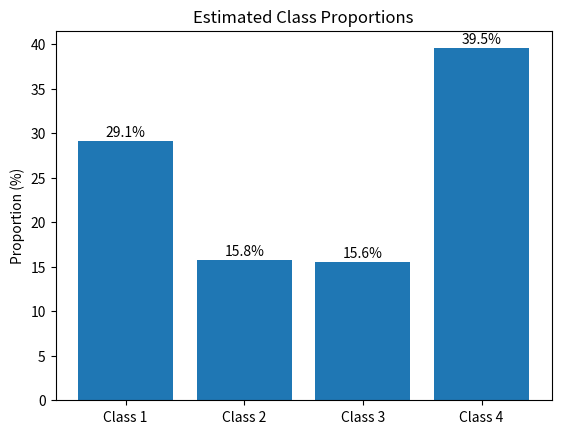

In [21]:
pi = model.weights_   # 클래스 비율 (크기 K 벡터)
plt.bar([f"Class {k+1}" for k in range(len(pi))], pi*100)
plt.ylabel("Proportion (%)")
plt.title("Estimated Class Proportions")
for i, v in enumerate(pi*100):
    plt.text(i, v+0.5, f"{v:.1f}%", ha="center")
plt.show()


시각화 2 : 변수-범주별 조건부 확률 히트맵 (세타)

/home/hschoi/.conda/envs/sleephi/lib/python3.11/site-packages/stepmix/stepmix.py:1224: FutureWarning: The provided callable <function mean at 0x7f59503eede0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return pd.pivot_table(


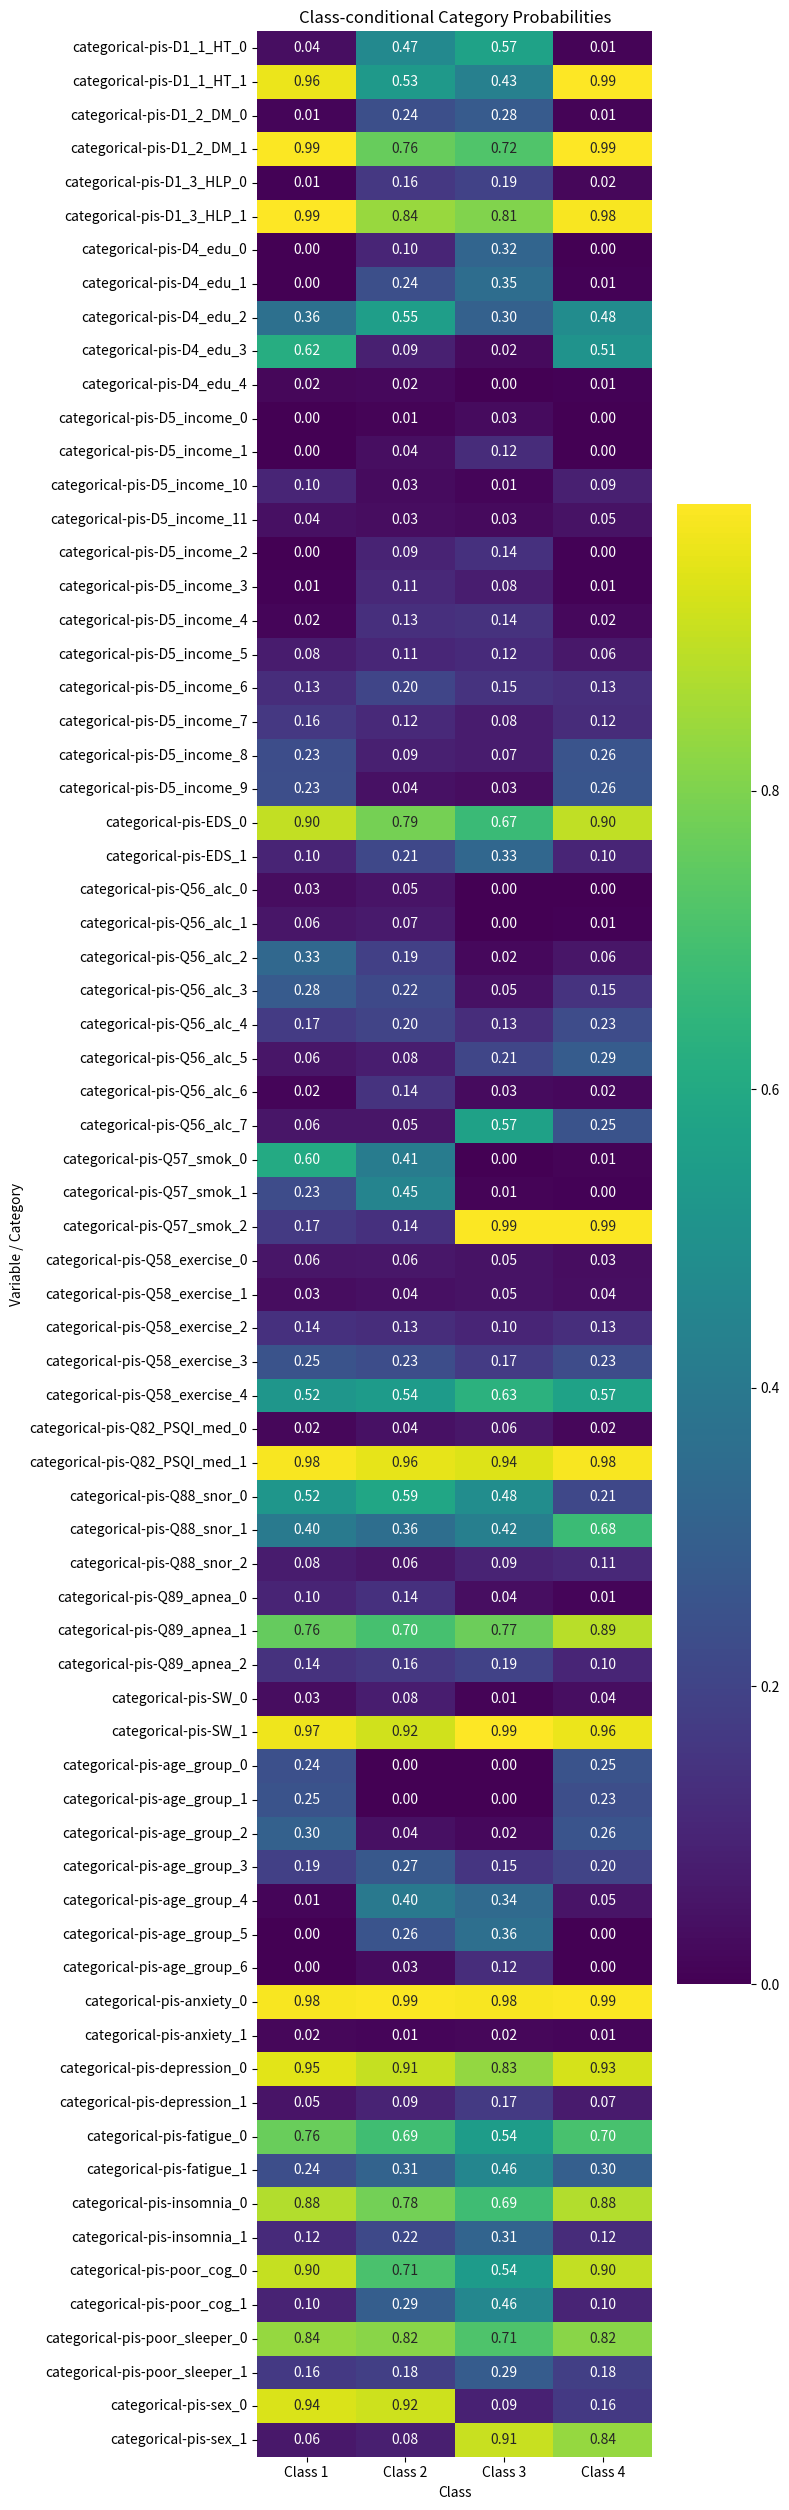

In [22]:
# 변수 이름을 전달하면 행 인덱스가 (variable[, category])로 정리된 DF가 옵니다.
mm = model.get_mm_df(x_names=cat_cols)   # 클래스가 열, 확률이 값
# 열 이름을 보기 좋게
mm.columns = [f"Class {int(c)+1}" if isinstance(c, (int, float)) else str(c) for c in mm.columns]

plt.figure(figsize=(8, max(6, 0.35*len(mm))))
sns.heatmap(mm, cmap="viridis", annot=True, fmt=".2f")
plt.title("Class-conditional Category Probabilities")
plt.ylabel("Variable / Category")
plt.xlabel("Class")
plt.tight_layout()
plt.show()

시각화 3 : 모델 선택 곡선 (BIC / AIC vs K)

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:02<00:00,  3.43it/s, max_LL=-3.49e+4, max_avg_LL=-14.8]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:04<00:00,  2.06it/s, max_LL=-3.41e+4, max_avg_LL=-14.4]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:15<00:00,  1.58s/it, max_LL=-3.37e+4, max_avg_LL=-14.3]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:13<00:00,  1.33s/it, max_LL=-3.34e+4, max_avg_LL=-14.1]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:21<00:00,  2.10s/it, max_LL=-3.31e+4, max_avg_LL=-14]


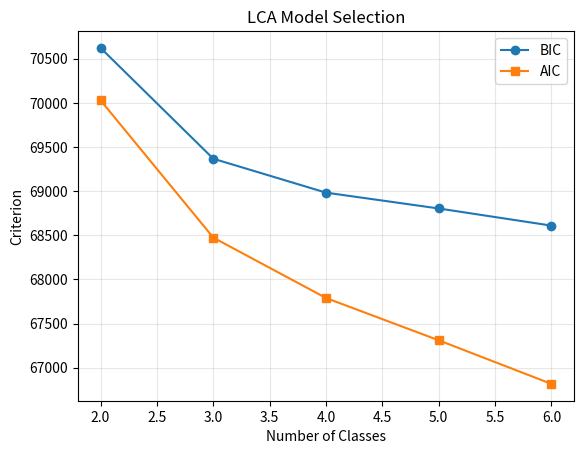

In [18]:
results = []
for K in range(2,7):
    m = StepMix(n_components=K, measurement="categorical", n_init=10, random_state=42)
    m.fit(X)
    results.append({"K": K, "AIC": m.aic(X), "BIC": m.bic(X)})

import pandas as pd
res_df = pd.DataFrame(results)

plt.plot(res_df["K"], res_df["BIC"], marker="o", label="BIC")
plt.plot(res_df["K"], res_df["AIC"], marker="s", label="AIC")
plt.xlabel("Number of Classes")
plt.ylabel("Criterion")
plt.title("LCA Model Selection")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
